# Phishing URL Detection

## Introduction

### Relevant Background Info

Phishing is a cybercrime that baits unknowing victims into clicking on URLs by acting like an authentic institution while contacting the victim through emails or other social media. Phishing is often used to steal user data, and with more and more of our data going online, the attack is becoming more and more vicious. Not only are phishing assaults dangerous to individuals, but they are also dangerous to huge corporations. For instance, one of the most extraordinary Phishing attacks includes the Colonial Pipeline scam, where over 3.4 billion euros were scammed out of the company. To counteract the dangers of phishing, our group will classify URLs as 'phishing' or 'legitimate' to warn victims before the attackers steal their sensitive information.

### Predictive Question

What attributes are the most important in classifying whether an URL is phishing or legitimate?

### Dataset

The dataset used in this project comes from: https://data.mendeley.com/datasets/c2gw7fy2j4/3/files/575316f4-ee1d-453e-a04f-7b950915b61b <br>
The dataset is used by the <a href="https://www.sciencedirect.com/science/article/pii/S0952197621001950#">article</a> which can be found on the <i><a href="https://www.sciencedirect.com/journal/engineering-applications-of-artificial-intelligence">Engineering Applications of Artificial Intelligence journal</a></i>.

## Preliminary Exploratory Data Analysis

In [11]:
library(tidyverse)
library(repr)
library(tidymodels)

### Reading the Data

In [14]:
options(repr.matrix.max.rows = 5)
phishing_data <- read_csv("https://brianhan.tech/media/dsci/dataset_phishing.csv")
phishing_data

Rows: 11430 Columns: 89
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): url, status
dbl (87): length_url, length_hostname, ip, nb_dots, nb_hyphens, nb_at, nb_qm...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,⋯,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,⋯,0,1,0,45,-1,0,1,1,4,legitimate
http://shadetreetechnology.com/V4/validation/a111aedc8ae390eabcfa130e041a10a4,77,23,1,1,0,0,0,0,0,⋯,1,0,0,77,5767,0,0,1,2,phishing
https://support-appleld.com.secureupdate.duilawyeryork.com/ap/89e6a3b4b063b8d/?cmd=_update&dispatch=89e6a3b4b063b8d1b&locale=_,126,50,1,4,1,0,1,2,0,⋯,1,0,0,14,4004,5828815,0,1,0,phishing
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,⋯,1,0,0,85,2836,2455493,0,0,4,legitimate
http://174.139.46.123/ap/signin?openid.pape.max_auth_age=0&amp;openid.return_to=https%3A%2F%2Fwww.amazon.co.jp%2F%3Fref_%3Dnav_em_hd_re_signin&amp;openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&amp;openid.assoc_handle=jpflex&amp;openid.mode=checkid_setup&amp;key=a@b.c&amp;openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&amp;openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&amp;&amp;ref_=nav_em_hd_clc_signin,477,14,1,24,0,1,1,9,0,⋯,1,1,1,0,-1,0,1,1,0,phishing


### Cleaning and Wrangling the Data into a tidy format

The data we have found has satisfied all the rules of being clean. Therefore, any data wrangling could make the data less clean. However, we will ***select the important columns*** and ***separate the dataset into a training set and a testing set***.

In [5]:
phishing_imp <- phishing_data |>
                select (url, length_url, length_hostname, nb_dots, nb_hyphens, nb_at, nb_qm, nb_and, nb_or, nb_eq, nb_underscore, nb_tilde,
                        nb_percent, nb_slash, nb_star, nb_colon, nb_comma, nb_semicolumn, nb_dollar, nb_space, http_in_path, https_token, 
                        ratio_digits_url, ratio_digits_host, nb_subdomains,longest_word_host, longest_word_path, avg_words_raw, avg_word_host, 
                        domain_registration_length, status)

phishing_split <- initial_split(phishing_imp, prop = 3/4, strata = status)
phishing_train <- training(phishing_split)
phishing_test <- testing(phishing_split)
phishing_train
phishing_test

url,length_url,length_hostname,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,⋯,https_token,ratio_digits_url,ratio_digits_host,nb_subdomains,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,domain_registration_length,status
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
http://www.crestonwood.com/router.php,37,19,3,0,0,0,0,0,0,⋯,1,0,0,3,11,6,5.750000,7,45,legitimate
http://www.iracing.com/tracks/gateway-motorsports-park/,55,15,2,2,0,0,0,0,0,⋯,1,0,0,2,7,11,6.333333,5,224,legitimate
http://www.mutuo.it,19,12,2,0,0,0,0,0,0,⋯,1,0,0,2,5,0,4.000000,4,170,legitimate
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://www.budgetbots.com/server.php/Server%20update/index.php?email=USER@DOMAIN.com,84,18,5,0,1,1,0,0,1,⋯,1,0.02380952,0.0000000,3,10,8,5.166667,6.50,211,phishing
http://174.139.46.123/ap/signin?openid.pape.max_auth_age=0&amp;openid.return_to=https%3A%2F%2Fwww.amazon.co.jp%2F%3Fref_%3Dnav_em_hd_re_signin&amp;openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&amp;openid.assoc_handle=jpflex&amp;openid.mode=checkid_setup&amp;key=a@b.c&amp;openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&amp;openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&amp;&amp;ref_=nav_em_hd_clc_signin,477,14,24,0,1,1,9,0,9,⋯,1,0.08595388,0.7857143,3,3,12,4.377778,2.75,0,phishing


url,length_url,length_hostname,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,⋯,https_token,ratio_digits_url,ratio_digits_host,nb_subdomains,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,domain_registration_length,status
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
http://rgipt.ac.in,18,11,2,0,0,0,0,0,0,⋯,1,0.00000000,0,2,5,0,5.000000,5.0,62,legitimate
https://technofizi.net/top-best-mp3-downloader-app-for-android-free-music-download/,83,14,1,9,0,0,0,0,0,⋯,0,0.01204819,0,1,10,10,5.454545,10.0,320,legitimate
https://blog.hubspot.com/marketing/email-open-click-rate-benchmark,66,16,2,4,0,0,0,0,0,⋯,0,0.00000000,0,2,7,9,5.875000,5.5,926,legitimate
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://www.siteglimpse.com/automationalley.com,46,19,3,0,0,0,0,0,0,⋯,1,0,0,3,11,15,8.0,7.0,187,legitimate
http://www.mypublicdomainpictures.com/,38,30,2,0,0,0,0,0,0,⋯,1,0,0,2,22,0,12.5,12.5,85,legitimate


### Data Summary

In [30]:
phishing_table_1 <- phishing_train |>
group_by (status) |>
summarize (n=n())

phishing_table_2 <- phishing_train |>
group_by(status) |>
summarize (mean_of_all_predictors = mean(length_url + length_hostname + nb_dots + nb_hyphens + nb_at + nb_qm + nb_and + nb_or + 
                                         nb_eq + nb_underscore + nb_tilde + nb_percent + nb_slash + nb_star + nb_colon + 
                                         nb_comma + nb_semicolumn + nb_dollar + nb_space + http_in_path + https_token + 
                                         ratio_digits_url + ratio_digits_host + nb_subdomains + longest_word_host + 
                                         longest_word_path + avg_words_raw + avg_word_host + domain_registration_length, 
                                         na.rm = TRUE))

phishing_table <- merge(x = phishing_table_1, y = phishing_table_2, by = "status")
phishing_table

status,n,mean_of_all_predictors
<chr>,<int>,<dbl>
legitimate,4286,725.9518
phishing,4286,522.9230


### Data Visualization

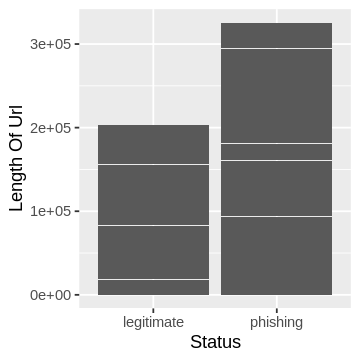

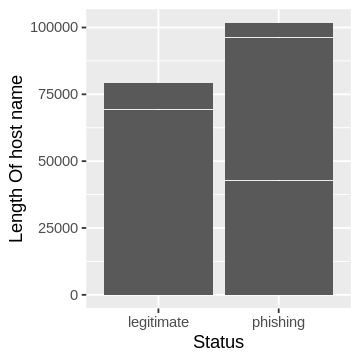

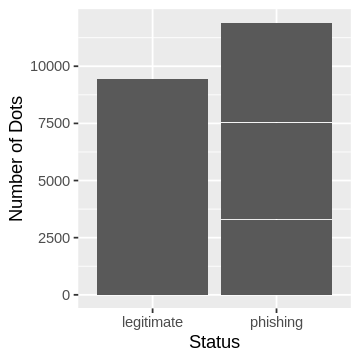

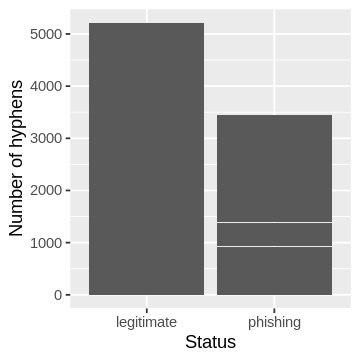

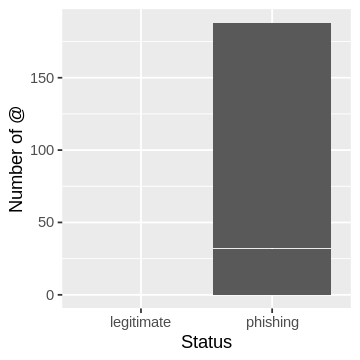

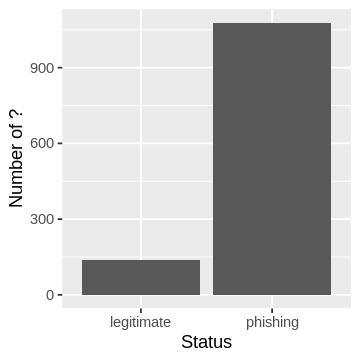

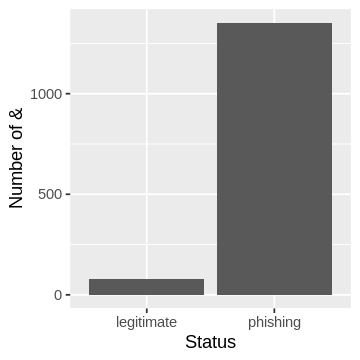

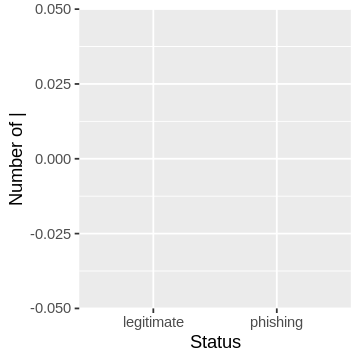

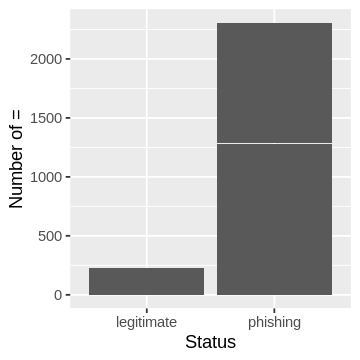

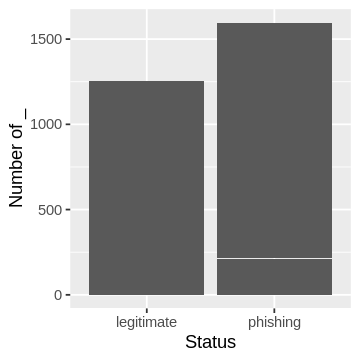

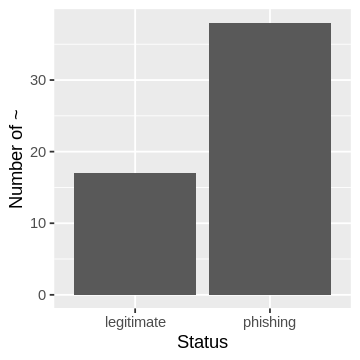

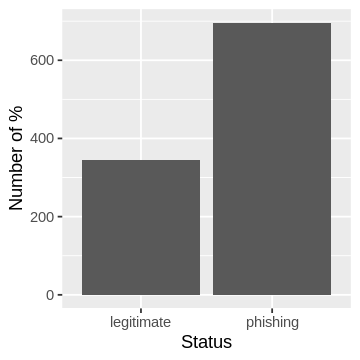

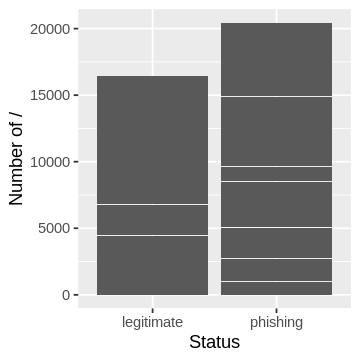

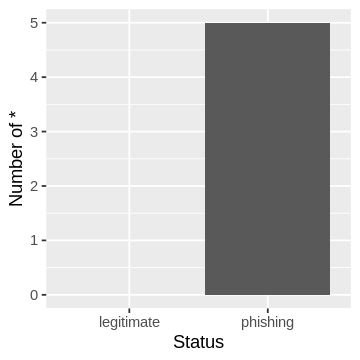

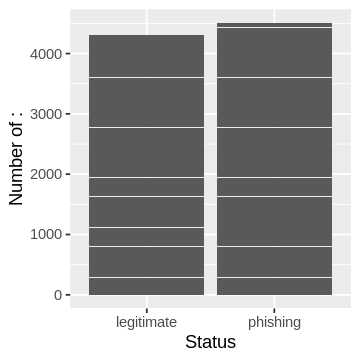

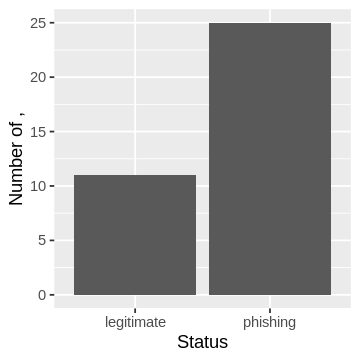

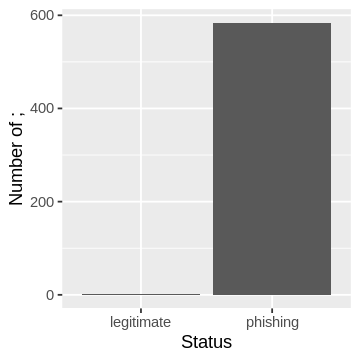

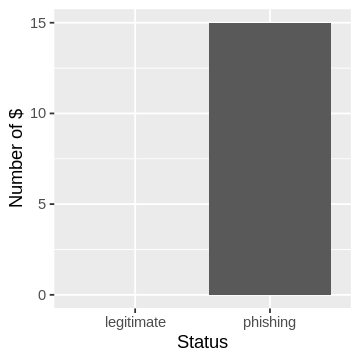

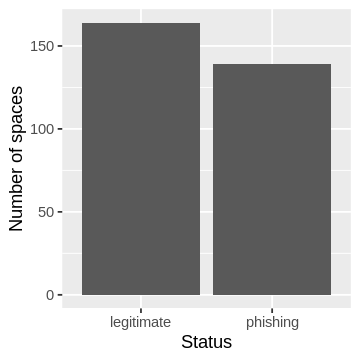

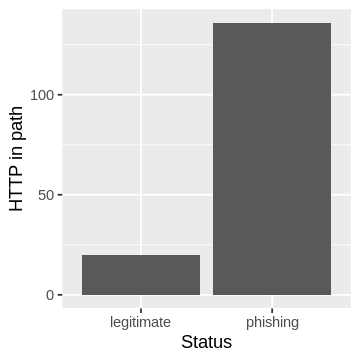

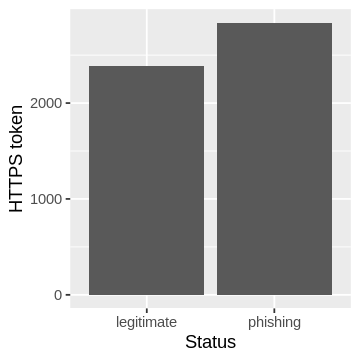

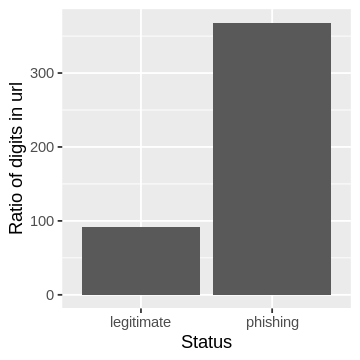

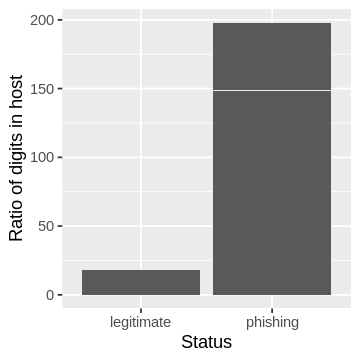

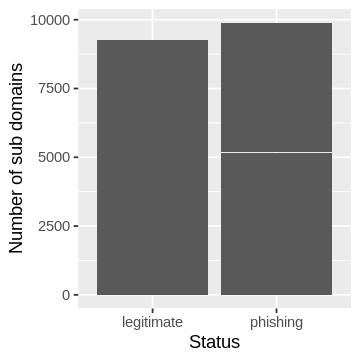

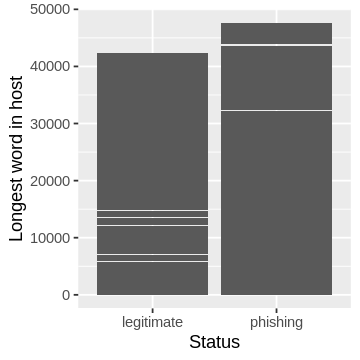

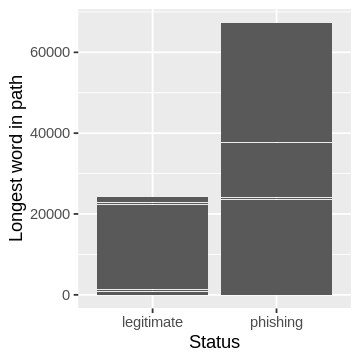

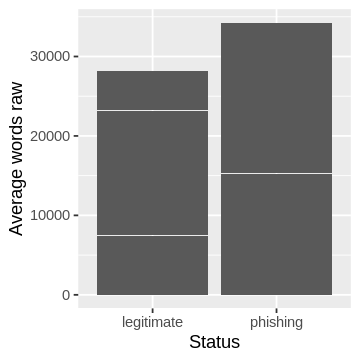

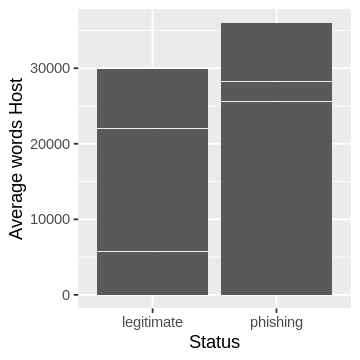

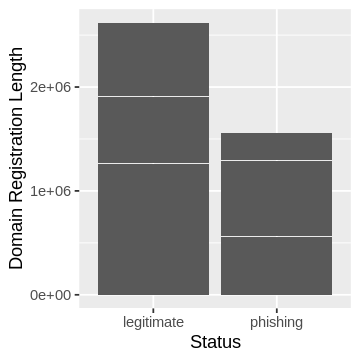

In [17]:
options (repr.plot.width = 3, repr.plot.height = 3)

phishing_plot_1 <- phishing_train |>
ggplot (aes ( x = status, y = length_url)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Length Of Url")
phishing_plot_1

phishing_plot_2 <- phishing_train |>
ggplot (aes ( x = status, y = length_hostname)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Length Of host name")
phishing_plot_2

phishing_plot_3 <- phishing_train |>
ggplot (aes ( x = status, y = nb_dots)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of Dots")
phishing_plot_3

phishing_plot_4 <- phishing_train |>
ggplot (aes ( x = status, y = nb_hyphens)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of hyphens")
phishing_plot_4

phishing_plot_5 <- phishing_train |>
ggplot (aes ( x = status, y = nb_at)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of @")
phishing_plot_5

phishing_plot_6 <- phishing_train |>
ggplot (aes ( x = status, y = nb_qm)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of ?")
phishing_plot_6

phishing_plot_7 <- phishing_train |>
ggplot (aes ( x = status, y = nb_and)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of &")
phishing_plot_7

phishing_plot_8 <- phishing_train |>
ggplot (aes ( x = status, y = nb_or)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of |")
phishing_plot_8

phishing_plot_9 <- phishing_train |>
ggplot (aes ( x = status, y = nb_eq)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of =")
phishing_plot_9

phishing_plot_10 <- phishing_train |>
ggplot (aes ( x = status, y = nb_underscore)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of _")
phishing_plot_10

phishing_plot_11 <- phishing_train |>
ggplot (aes ( x = status, y = nb_tilde)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of ~")
phishing_plot_11

phishing_plot_12 <- phishing_train |>
ggplot (aes ( x = status, y = nb_percent)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of %")
phishing_plot_12

phishing_plot_13 <- phishing_train |>
ggplot (aes ( x = status, y = nb_slash)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of /")
phishing_plot_13

phishing_plot_14 <- phishing_train |>
ggplot (aes ( x = status, y = nb_star)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of *")
phishing_plot_14

phishing_plot_15 <- phishing_train |>
ggplot (aes ( x = status, y = nb_colon)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of :")
phishing_plot_15

phishing_plot_16 <- phishing_train |>
ggplot (aes ( x = status, y = nb_comma)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of ,")
phishing_plot_16

phishing_plot_17 <- phishing_train |>
ggplot (aes ( x = status, y = nb_semicolumn)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of ;")
phishing_plot_17

phishing_plot_18 <- phishing_train |>
ggplot (aes ( x = status, y = nb_dollar)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of $")
phishing_plot_18

phishing_plot_19 <- phishing_train |>
ggplot (aes ( x = status, y = nb_space)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of spaces")
phishing_plot_19

phishing_plot_20 <- phishing_train |>
ggplot (aes ( x = status, y = http_in_path)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("HTTP in path")
phishing_plot_20

phishing_plot_21 <- phishing_train |>
ggplot (aes ( x = status, y = https_token)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("HTTPS token")
phishing_plot_21

phishing_plot_22 <- phishing_train |>
ggplot (aes ( x = status, y = ratio_digits_url)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Ratio of digits in url")
phishing_plot_22

phishing_plot_23 <- phishing_train |>
ggplot (aes ( x = status, y = ratio_digits_host)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Ratio of digits in host")
phishing_plot_23

phishing_plot_24 <- phishing_train |>
ggplot (aes ( x = status, y = nb_subdomains)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Number of sub domains")
phishing_plot_24

phishing_plot_25 <- phishing_train |>
ggplot (aes ( x = status, y = longest_word_host)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Longest word in host")
phishing_plot_25

phishing_plot_26 <- phishing_train |>
ggplot (aes ( x = status, y = longest_word_path)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Longest word in path")
phishing_plot_26

phishing_plot_27 <- phishing_train |>
ggplot (aes ( x = status, y = avg_words_raw)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Average words raw")
phishing_plot_27

phishing_plot_28 <- phishing_train |>
ggplot (aes ( x = status, y = avg_word_host)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Average words Host")
phishing_plot_28

phishing_plot_29 <- phishing_train |>
ggplot (aes ( x = status, y = domain_registration_length)) +
geom_bar(stat = "identity") +
xlab("Status") +
ylab("Domain Registration Length")
phishing_plot_29

## Methods

### How we will conduct data analysis

We will be classifying the URLs using K-nearest neighbours classification. To use this type of classification, we have chosen a list of relevant predictors which predict ***status*** (URL is phishing or legitimate), and we will use **cross-validation** to get an optimal value of K.

Relevant Predictors:
- Length of the URL (length_url)
- Length of the hostname (length_hostname)
- Number of dots (nb_dots)
- Number of hyphens (nb_hyphens)
- Number of @ (nb_at)
- Number of ? (nb_qm)
- Number of & (nb_and)
- Number of | (nb_or)
- Number of = (nb_eq)
- Number of _ (nb_underscore)
- Number of ~ (nb_tilde)
- Number of % (nb_percent)
- Number of / (nb_slash)
- Number of * (nb_star)
- Number of : (nb_colon)
- Number of , (nb_comma)
- Number of ; (nb_semicolumn)
- Number of $ (nb_dollar)
- Number of spaces (nb_space)
- HTTP in path (http_in_path)
- HTTPS token (https_token)
- Ratio of digits in URL (ratio_digits_url)
- Ratio of digits in host (ratio_digits_host)
- Number of subdomains (nb_subdomains)
- Longest word in host (longest_word_host)
- Longest word in path (longest_word_path)
- Average words Raw (avg_words_raw)
- Average word host (avg_word_host)
- Domain Registration Length (domain_registration_length)

After classifying the URLs, we will be testing the accuracy of the model whilst adding and removing predictors. 

### How we will visualize the results

- Correlation matrix  - enable us to see patterns in the data, allowing us to see which attributes are the best predictors of the legitimacy of the URL.
- Bell curves - show predictors' mean and standard deviations and how they relate to the legitimacy of URLs. We can compare the mean and standard deviation of a predictor for a legitimate URL and a predictor for a phishing URL. The best predictors to use are the predictors that differ the most between legitimate and phishing.
- Bar graphs - showing the model accuracy estimate with the removal of each predictor.

## Expected Outcomes and Significance

We expect to find specific attributes that stick out from the rest. These attributes probably include HTTPS tokens and the amount of non-alphanumeric characters in the URL. These findings will allow us to reduce the number of predictors used to classify phishing/legitimate URLs, meaning that we can decrease the number of computations when trying to find bad actors stealing one's information. This will lead to future questions like:
- What percentage of phishing is prevented by your email service?
- Would phishing URLs advance to the point they will be undetectable?
- What new types of phishing attacks come to play in the future?